941  x  1333


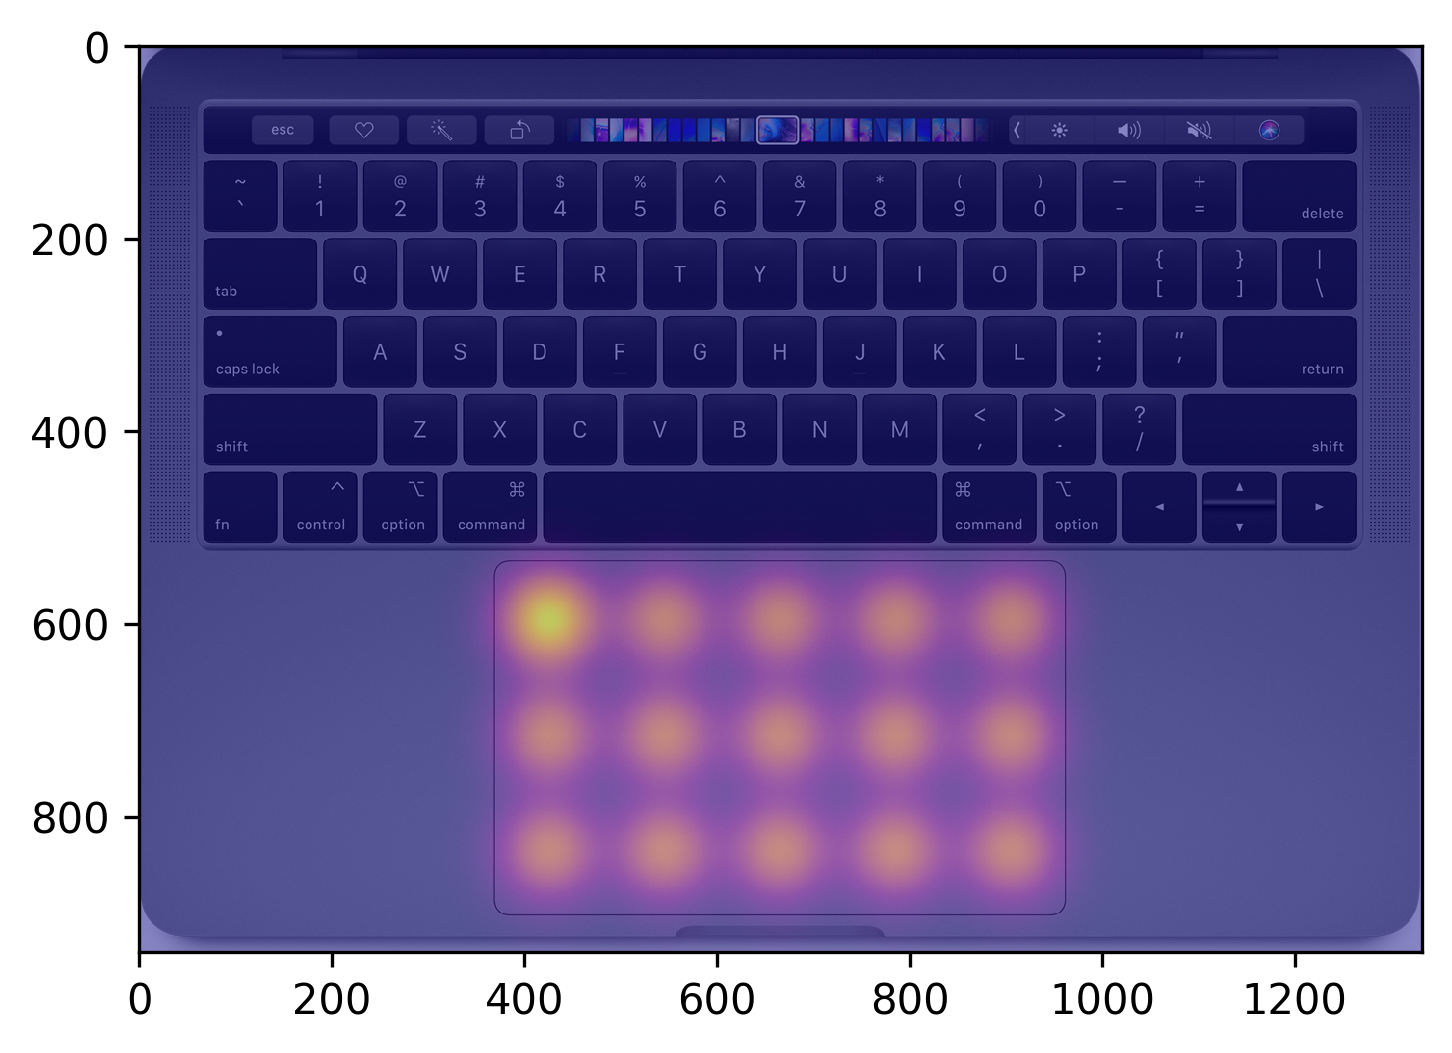

In [ ]:
%matplotlib inline
import heatmaps as hm
hm.genHeatmaps(UDP_PORT=9000, display=True)